# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import seaborn.apionly as sns
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

In [2]:
np.random.seed(9001)
df = pd.read_csv('hw6_dataset.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,-0.144,-0.143,-0.1160,-0.1030,0.226,0.210,-0.9800,-0.780,-0.474,-0.447,...,0.925,0.516,0.34400,0.906,-1.1300,-0.552,0.553,-0.417,0.2560,0.0
1,-0.011,0.138,-0.2230,-0.1730,0.188,0.284,-0.0522,-0.256,0.129,0.427,...,-0.593,0.452,0.00785,-0.533,-0.0789,0.705,0.906,0.216,-0.0723,0.0
2,0.212,-0.313,0.2660,0.2320,-1.190,-1.150,-1.8100,-1.560,-1.250,-1.200,...,-0.816,1.570,0.39400,1.340,-1.1800,-2.700,-0.926,-2.650,-0.0447,0.0
3,0.215,-0.184,0.0274,0.0494,0.443,0.463,-1.0500,-0.941,-0.531,-0.394,...,0.634,0.111,0.37100,0.859,-0.9930,-0.492,0.363,0.326,-0.0528,0.0
4,0.279,-0.197,0.1270,0.0973,-0.213,-0.150,-1.3200,-0.994,-1.110,-1.090,...,-0.640,0.485,0.29500,0.403,-1.1200,-0.343,0.468,-0.820,0.4350,0.0


In [3]:
msk = np.random.rand(len(df)) < 0.75
df_train = df[msk]
df_test = df[~msk]
df_train =df_train.rename(columns = {117:'label'})
df_test = df_test.rename(columns = {117:'label'})
df_train.head()


,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,label
0,-0.14400,-0.1430,-0.1160,-0.1030,0.226,0.210,-0.980,-0.780,-0.474,-0.447,...,0.925,0.5160,0.344,0.906,-1.130,-0.552,0.553,-0.417,0.2560,0.0
3,0.21500,-0.1840,0.0274,0.0494,0.443,0.463,-1.050,-0.941,-0.531,-0.394,...,0.634,0.1110,0.371,0.859,-0.993,-0.492,0.363,0.326,-0.0528,0.0
5,0.00922,-0.1380,0.1690,0.1540,-0.391,-0.397,-1.690,-1.450,-0.546,-0.527,...,-0.277,0.6990,0.371,0.481,-1.060,-0.526,0.550,-0.284,0.1550,0.0
6,0.05690,0.1920,0.3020,0.2720,-0.484,-0.473,0.348,0.256,-0.607,-0.355,...,0.206,-0.0599,-1.070,-0.536,0.864,0.527,0.282,0.817,-0.2830,0.0
9,-0.09250,0.0102,-0.2580,-0.2530,0.452,0.622,-1.790,-1.450,-1.170,-1.180,...,3.230,1.2000,0.270,2.220,-1.190,-1.350,0.255,-1.530,0.1960,0.0


In [4]:
#separating dependant variable from predictors
x_train1 = df_train.loc[:, df_train.columns != 'label']
y_train1 = df_train['label']
x_test1 = df_test.loc[:, df_test.columns != 'label']
y_test1 = df_test['label']

#'all-zeroes' model
all_zeroes = np.zeros_like(y_test1)

log_regr = LogisticRegressionCV(random_state= 123, penalty='l2')
log_regr.fit(x_train1, y_train1)
print("Logistic Regression Score:", log_regr.score(x_test1, y_test1))
print("All-Zeroes:", accuracy_score(y_test1, all_zeroes))


Logistic Regression Score: 0.995026040143
All-Zeroes: 0.994206799696


    A. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients?
    - According to their accuracy scores the Logistic Regression Classifier is only slightly better than the All-Zeroes classifier (difference is about  0.00082).
    B. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    - The difference in accuracy score is very small, which means that I would not declare logistic regression as a better classifier, because it costs much more to perform computationally than the all zeroes classifier and its results are not significantly better.

In [5]:
con_matrix = metrics.confusion_matrix(y_test1, log_regr.predict(x_test1))
con_matrix_zero = metrics.confusion_matrix(y_test1, all_zeroes)
print("Confusion Matrix for Logistic Regression model:\n",con_matrix)
print("Confusion Matrix All Zeros:\n",con_matrix_zero)

Confusion Matrix for Logistic Regression model:
 [[16984     6]
 [   79    20]]
Confusion Matrix All Zeros:
 [[16990     0]
 [   99     0]]


In [6]:
def get_rates(confusion_matrix):
    rates = dict()
    TN = confusion_matrix[0][0]
    FN = confusion_matrix[0][1]
    TP = confusion_matrix[1][1]
    FP = confusion_matrix[1][0]
    rates["True Positive Rate"] = (TP/(TP+FN))
    rates["False Positive Rate"] = (FP/(FP+TN))
    rates["True Negative Rate"] = (TN/(FP+TN))
    return rates

In [7]:
print("Logistic Model: \n")
for k, v in get_rates(con_matrix).items():
    print(k, v)
print("\nAll Zeroes: \n")
for k, v in get_rates(con_matrix_zero).items():
    print(k, v)


Logistic Model: 

True Positive Rate 0.769230769231
False Positive Rate 0.00462990095528
True Negative Rate 0.995370099045

All Zeroes: 

True Positive Rate nan
False Positive Rate 0.00579320030429
True Negative Rate 0.994206799696


C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.
- The true positive rate describes the rate at which our model predicts that a patient has cancer when they actually do have cancer and the true negative rate describes the rate at which our model predicts that a patient is healthy when they are in fact healthy.  

What is the false positive rate of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?
- The false positive rate of the fitted classifier is 0.00463. This means that 0.46% of patients who are healthy are incorrectly classified as having cancer. The true negative rate would be equal to 1 minus the false positive rate. The true positive rate, however, cannot be directly derived from the false positive rate, because the equation for a true positive rate is TPR = TP/(TP+FN) and the false positive rate equation is FPR = FP/(FP + TN). A classifier with a high false positive rate would be undesirable, because it would incorrectly identify more people as having cancer and would not filter out as many people that were healthy.

## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

In [8]:
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

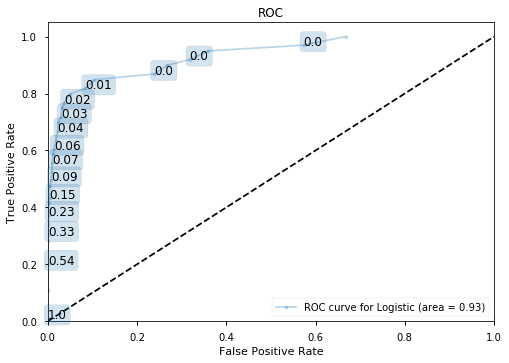

In [9]:
sns.set_context("notebook")
ax=make_roc("Logistic", log_regr, y_test1, x_test1, labe=10, skip=5)


In [10]:
fpr, tpr, thresholds = roc_curve(y_test1, log_regr.predict_proba(x_test1)[:,1])
target_fprs = [0, 0.1, 0.5, 0.9]

In [11]:
for tgt in target_fprs:
    if tgt == 0.9:
        idx = np.where((fpr < 0.15) & (fpr > 0.1))
    elif tgt == 0:
        idx = np.where(fpr == 0)
    else:
        idx = np.where((fpr > (tgt - 0.05)) & (fpr < (tgt + 0.05)))
    tprs = tpr[idx]
    max_tpr = np.max(tprs)
    idz = np.where(tpr == max_tpr)
    thresh = thresholds[idz]
    min_thresh = np.min(thresh)
    idq = np.where(thresholds == min_thresh)
    print("FPR:", fpr[idq])
    print("TPR:", tpr[idq])
    print("Threshold: {}\n".format(thresholds[idq]))


FPR: [  5.88581519e-05]
TPR: [ 0.08080808]
Threshold: [ 0.9305692]

FPR: [ 0.17628016]
TPR: [ 0.85858586]
Threshold: [ 0.00256634]

FPR: [ 0.57321954]
TPR: [ 0.96969697]
Threshold: [ 0.00012183]

FPR: [ 0.17628016]
TPR: [ 0.85858586]
Threshold: [ 0.00256634]



Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
- The classifer's FPR increases as the threshold decreases. This is how we would expect the FPR to be influenced by the threshold, because as the threshold for a point being classified as positive is lowered more incorrect cassifications would slip through.

In [12]:
#create an array of (FNR*2 + FPR) and find the min
sum_fnr_tpr = [(((1-tpr[i]) * 2) + fpr[i]) for i in range(len(fpr))]
min_sum = np.min(sum_fnr_tpr)
idw = np.where(sum_fnr_tpr == min_sum)
print("The new threshold that we would recommend is {} \n".format(thresholds[idw]))
print("At this threshold the FPR = {} and the TPR = {}".format(fpr[idw], tpr[idw]))


The new threshold that we would recommend is [ 0.00580326] 

At this threshold the FPR = [ 0.10453208] and the TPR = [ 0.84848485]


In [13]:
auc(fpr, tpr)

0.93463059078126776

The area under the curve for the all zeroes classifier is 0 because the false positive rate never changes and there is no area underneath a vertical line. The area under the curve of the logistic classifier model is 0.93, which is much greater than that of the all zeroes classifier and demonstrates to us that the logistic classifer is better than the all zeroes classifier than the accuracy score would indicate. This is because the accuracy score only gives the FPR and TPR at one threshold, rather than across many thresholds.

## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



In [14]:
np.random.seed(9001)
df_miss = pd.read_csv('hw6_dataset_missing.csv')
df_miss1 = df_miss.copy()
df_miss.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,type
0,0,0.1290,-0.2160,0.2880,0.2370,-0.993,-0.9550,-1.620,-1.470,-1.0100,...,-1.1900,1.1000,0.395,2.060,-1.180,-2.8500,-1.290,-2.100,0.0121,0.0
1,1,0.0989,0.1160,0.3130,0.2810,-0.188,-0.2790,0.173,0.445,0.4320,...,-0.0181,0.2480,-0.869,-0.190,0.451,0.6980,0.363,1.030,-0.2490,0.0
2,2,0.0215,0.1590,0.5790,0.5020,-0.342,-0.2740,-0.172,-0.164,0.2160,...,0.0702,0.0200,0.397,-0.800,0.173,0.7380,0.465,0.440,-0.2880,0.0
3,3,-0.2170,-0.3570,-0.0539,-0.0688,0.445,0.6380,0.436,0.351,0.0401,...,NaN,0.0622,0.269,-0.217,-1.030,0.0276,0.472,-0.390,0.3660,0.0
4,4,-0.0846,0.0166,0.4240,0.3520,-0.259,-0.0947,0.119,-0.162,0.3020,...,0.7190,0.3250,-0.286,-0.528,-0.704,0.8530,0.953,-0.116,-0.1190,0.0


In [15]:
print(df_miss.shape)
print(100*df_miss.type.mean())

(24999, 119)
0.6440257610304413


In [16]:
# remove all observations that contain and missing values
df_miss_all = df_miss.dropna(how = 'any')
print(df_miss_all.shape)

# checking how dropping observations affected the type outcome
print(100*df_miss_all.type.mean())
df_miss_all.head()

(1436, 119)
0.20891364902506965


,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,type
4,4,-0.0846,0.0166,0.4240,0.3520,-0.259,-0.0947,0.119,-0.1620,0.302,...,0.719,0.325,-0.2860,-0.528,-0.7040,0.85300,0.953,-0.1160,-0.1190,0.0
54,54,-0.0713,0.1630,-0.4380,-0.3920,0.506,0.5750,-0.450,0.0465,-1.080,...,0.158,0.193,-0.9420,-0.231,0.0466,0.98400,0.770,0.2890,-0.2050,0.0
55,55,0.0108,0.1640,0.4180,0.3540,-0.409,-0.4520,1.660,1.3400,0.400,...,-1.010,-1.950,0.4750,-0.228,0.2810,-0.00374,-1.850,0.0613,-0.4080,0.0
81,81,-0.1290,0.0187,-0.2010,-0.1760,0.512,0.5530,-1.650,-1.4200,-0.429,...,-0.459,1.100,-0.0382,0.157,-1.1900,0.42800,1.040,-3.2000,5.7300,0.0
96,96,-0.0366,-0.0291,0.0428,0.0453,0.799,0.9050,-0.306,-0.0993,0.201,...,0.962,0.747,-0.6210,0.653,-0.6690,0.86000,0.998,0.5390,-0.0736,0.0


In [17]:
# 75 - 25 train-test split
msk = np.random.rand(len(df_miss_all)) < 0.75
df_train2 = df_miss_all[msk]
df_test2 = df_miss_all[~msk]
df_train2.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,type
4,4,-0.084600,0.0166,0.4240,0.3520,-0.2590,-0.0947,0.119,-0.162,0.302,...,0.719,0.325,-0.2860,-0.5280,-0.704,0.853,0.9530,-0.116,-0.1190,0.0
81,81,-0.129000,0.0187,-0.2010,-0.1760,0.5120,0.5530,-1.650,-1.420,-0.429,...,-0.459,1.100,-0.0382,0.1570,-1.190,0.428,1.0400,-3.200,5.7300,0.0
99,99,0.012100,0.1880,0.0819,0.0794,-0.1130,-0.0859,-0.556,-0.564,0.458,...,-0.411,0.280,1.0200,-0.0604,0.158,0.608,0.9370,0.765,-0.0786,0.0
105,105,-0.369000,-0.0302,-0.1490,-0.1340,0.9610,1.0200,1.480,1.680,-0.208,...,-0.405,-1.860,0.2510,-0.9130,1.460,-0.275,-1.9200,0.382,-0.2820,0.0
144,144,-0.000257,-0.3280,-0.0651,-0.0632,0.0055,0.0372,-1.070,-1.020,-0.523,...,1.740,0.991,0.3490,1.8900,-1.180,-1.340,-0.0111,-0.612,0.0623,0.0


In [18]:
# splitting training and testing by predictors and y-value
x_train2 = df_train2.loc[:, df_train.columns != 'type']
y_train2 = df_train2['type']
x_test2 = df_test2.loc[:, df_test.columns != 'type']
y_test2 = df_test2['type']

In [19]:
# Classification rate
log_miss_all = LogisticRegressionCV(penalty='l2')
log_miss_all.fit(x_train2, y_train2)
print("Logistic Regression Score:", log_miss_all.score(x_test2, y_test2))

C:\Users\charl\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Logistic Regression Score: 0.994382022472


In [20]:
# TPR (true prositive rate) in test set
con_matrix1 = metrics.confusion_matrix(y_test2, log_miss_all.predict(x_test2))
print("Confusion Matrix for Logistic Regression model:\n",con_matrix1)

Confusion Matrix for Logistic Regression model:
 [[354   0]
 [  2   0]]


In [21]:
# TPR
print("Logistic Model: \n")
for k, v in get_rates(con_matrix1).items():
    print(k, v)

Logistic Model: 

True Positive Rate nan
False Positive Rate 0.00561797752809
True Negative Rate 0.994382022472


C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


# PART 2: mean imputation

In [22]:
# getting 
x_cols = df_miss1.loc[:, df_miss1.columns != 'type']
x_cols_names = x_cols.columns

In [23]:
# filling missing values with mean
#df_miss1[x_cols_names]=df_miss1[x_cols_names].fillna(df_miss1.mean().iloc[0])
#df_miss1
df_miss1[df_miss1.columns]=df_miss1[df_miss1.columns].fillna(df_miss1.mean().iloc[0])

In [24]:
# 75 - 25 train-test split
msk = np.random.rand(len(df_miss1)) < 0.75
df_train3 = df_miss1[msk]
df_test3 = df_miss1[~msk]
df_train3.head()

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,type
0,0,0.1290,-0.2160,0.2880,0.2370,-0.993,-0.9550,-1.620,-1.470,-1.0100,...,-1.1900,1.1000,0.395,2.0600,-1.180,-2.8500,-1.290,-2.100,0.0121,0.0
2,2,0.0215,0.1590,0.5790,0.5020,-0.342,-0.2740,-0.172,-0.164,0.2160,...,0.0702,0.0200,0.397,-0.8000,0.173,0.7380,0.465,0.440,-0.2880,0.0
3,3,-0.2170,-0.3570,-0.0539,-0.0688,0.445,0.6380,0.436,0.351,0.0401,...,12499.0000,0.0622,0.269,-0.2170,-1.030,0.0276,0.472,-0.390,0.3660,0.0
4,4,-0.0846,0.0166,0.4240,0.3520,-0.259,-0.0947,0.119,-0.162,0.3020,...,0.7190,0.3250,-0.286,-0.5280,-0.704,0.8530,0.953,-0.116,-0.1190,0.0
5,5,0.0878,0.2180,0.9710,0.8340,-1.410,-1.3100,0.564,0.707,0.7220,...,-0.4800,-0.9380,-0.135,-0.0344,1.060,0.2040,-0.716,0.595,-0.1710,0.0


In [25]:
# splitting training and testing by predictors and y-value
x_train3 = df_train3.loc[:, df_train.columns != 'type']
y_train3 = df_train3['type']
x_test3 = df_test3.loc[:, df_test.columns != 'type']
y_test3 = df_test3['type']

In [26]:
# Classification rate
log_miss1 = LogisticRegressionCV(penalty='l2')
log_miss1.fit(x_train3, y_train3)
print("Logistic Regression Score:", log_miss1.score(x_test3, y_test3))

Logistic Regression Score: 0.994947025265


In [27]:
# TPR (true prositive rate) in test set
con_matrix2 = metrics.confusion_matrix(y_test3, log_miss1.predict(x_test3))
print("Confusion Matrix for Logistic Regression model:\n",con_matrix2)

Confusion Matrix for Logistic Regression model:
 [[6104    0]
 [  31    0]]


In [28]:
# TPR
print("Logistic Model: \n")
for k, v in get_rates(con_matrix2).items():
    print(k, v)

Logistic Model: 

True Positive Rate nan
False Positive Rate 0.00505297473513
True Negative Rate 0.994947025265


C:\Users\charl\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


# PART 3: model-based imputatation

In [29]:
# making a copy of the dataset
df_miss2 = df_miss.copy()

In [30]:
#using dataset without NAs to build model
from sklearn.metrics import mean_squared_error

# columns with all the data
df1 = df_miss_all.iloc[:,1:]
# all columns, with even missing values
df_miss1 = df_miss2.iloc[:,1:]
x_temp = df1.loc[:, df1.columns != 'type']
y_temp = df1['type']

In [31]:
# columns that have missing values
mcols = df_miss1.columns[df_miss1.isnull().any()]

In [32]:
from sklearn.linear_model import LinearRegression

#for mcol in y_temp[mcols]: 
regress = LinearRegression()
regress.fit(x_temp,y_temp)
y_hat = regress.predict(x_temp)

In [33]:
df_miss1.isnull().sum()

1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
30         0
        ... 
89         0
90         0
91         0
92         0
93      3894
94      3903
95      3897
96      3913
97      3899
98      3903
99      3911
100     3907
101     3889
102     3953
103     3911
104     3928
105     3891
106     3892
107     3928
108     3909
109     3914
110        0
111        0
112        0
113        0
114        0
115        0
116        0
117        0
type       0
Length: 118, dtype: int64

In [34]:
#create a list of columns that have NaN values
nan_cols = df_miss1.columns[df_miss1.isnull().any()].tolist()

In [35]:
#drop all columns with null values, this dataset will be what we use to fit linear regressions and estimate values to impute
df_no_null_cols = df_miss1.dropna(axis = 1, how='any')
df_no_null_colsx = df_no_null_cols.loc[:, df_no_null_cols.columns != 'type']
#impute_model is a linear regression model that we will fit to impute missing values
impute_model = LinearRegression()

In [36]:
#df_imputed is basically an accumulator that will end up being our full imputed dataset
df_imputed = df_miss1.copy()
df_iterator = df_miss1.iterrows()

In [37]:
#iterate through the list of columns that contain NaN values
for i in nan_cols:
    #this will be an array of rows that have null values
    null_rows = [p for p in range(len(df_miss1)) if df_miss1.iloc[p].isnull()[i]]
    
    x_predict = []
    impute_indices = []
    x_fit = []
    y_fit = []
    
    for h in range(len(df_no_null_cols)):
        if h in null_rows:
            x_predict.append(df_no_null_colsx.iloc[h].tolist())
            impute_indices.append(h)
        else:
            x_fit.append(df_no_null_colsx.loc[h].tolist())
            y_fit.append(df_no_null_cols.iloc[h]['type'].tolist())
    
    x_fit1 = np.asarray(x_fit)
    y_fit1 = np.asarray(y_fit)
    x_predict1 = np.asarray(x_predict)
    impute_model.fit(x_fit1, y_fit1)
    to_impute = impute_model.predict(x_predict1)
    
    for z in range(len(df_imputed)):
        if z in impute_indices:
            df_imputed[i][z] = to_impute[impute_indices.index(z)]
    print("1")
    
df_imputed.head()

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


,1,2,3,4,5,6,7,8,9,10,...,109,110,111,112,113,114,115,116,117,type
0,0.1290,-0.2160,0.2880,0.2370,-0.993,-0.9550,-1.620,-1.470,-1.0100,-1.0100,...,-1.190000,1.1000,0.395,2.060,-1.180,-2.8500,-1.290,-2.100,0.0121,0.0
1,0.0989,0.1160,0.3130,0.2810,-0.188,-0.2790,0.173,0.445,0.4320,0.9440,...,-0.018100,0.2480,-0.869,-0.190,0.451,0.6980,0.363,1.030,-0.2490,0.0
2,0.0215,0.1590,0.5790,0.5020,-0.342,-0.2740,-0.172,-0.164,0.2160,0.0709,...,0.070200,0.0200,0.397,-0.800,0.173,0.7380,0.465,0.440,-0.2880,0.0
3,-0.2170,-0.3570,-0.0539,-0.0688,0.445,0.6380,0.436,0.351,0.0401,-0.1140,...,0.006779,0.0622,0.269,-0.217,-1.030,0.0276,0.472,-0.390,0.3660,0.0
4,-0.0846,0.0166,0.4240,0.3520,-0.259,-0.0947,0.119,-0.162,0.3020,-0.1700,...,0.719000,0.3250,-0.286,-0.528,-0.704,0.8530,0.953,-0.116,-0.1190,0.0


In [44]:
# 75 - 25 train-test split
msk = np.random.rand(len(df_imputed)) < 0.75
df_train4 = df_imputed[msk]
df_test4 = df_imputed[~msk]

In [45]:
x_train4 = df_train4.loc[:, df_train.columns != 'type']
y_train4 = df_train4['type']
x_test4 = df_test4.loc[:, df_test.columns != 'type']
y_test4 = df_test4['type']

In [46]:
# Classification rate
log_miss1 = LogisticRegressionCV(penalty='l2')
log_miss1.fit(x_train4, y_train4)
print("Logistic Regression Score:", log_miss1.score(x_test4, y_test4))

Logistic Regression Score: 0.999837846603


In [47]:
# TPR (true prositive rate) in test set
con_matrix3 = metrics.confusion_matrix(y_test4, log_miss1.predict(x_test4))
print("Confusion Matrix for Logistic Regression model:\n",con_matrix3)

Confusion Matrix for Logistic Regression model:
 [[6124    1]
 [   0   42]]


In [49]:
# TPR
print("Logistic Model: \n")
for k, v in get_rates(con_matrix3).items():
    print(k, v)

Logistic Model: 

True Positive Rate 0.976744186047
False Positive Rate 0.0
True Negative Rate 1.0


## APCOMP209a - Homework Question


This problem walks you through the derivation of the **likelihood equations** for a generalized linear model (GLM). Suppose that the random component of the GLM is in the univariate natural exponential family, so that
$$f(y_i|\theta_i) = h(y_i) e^{y_i\theta_i - b(\theta_i)}$$
Define the individual log-likelihood for each observation $i$ as
$$l_i(\theta_i) \equiv \log f(y_i|\theta_i)$$
with linear predictor
$$\eta_i = x_i^T\beta = g(\mu_i)$$
for some link function $g$ and where $\mu_i=E(Y_i)$.

1. Use the above expressions to write a simplified expression for the log-likelihood $l(\theta)$ for the entire dataset, $y_1, \dots, y_n$.

2. Use the chain rule to express $\frac{\partial l_i}{\partial \beta_j}$ in terms of the derivatives of $l_i, \theta_i, \mu_i$, and $\eta_i$. (*Hint*: Think carefully about which variables are related to which, and in what way. For example, for which of the above variables do you know the derivative with respect to $\beta_j$?)

3. Compute the derivatives for $\frac{\partial l_i}{\partial \theta_i}$ and $\frac{\partial \eta_i}{\partial \beta_j}$.

4. Express $\mu_i$ in terms of $\theta_i$, and use this relationship to compute $\frac{\partial \theta_i}{\partial \mu_i}$. (\emph{Hint}: Recall the cumulant function of a natural exponential family, and assume that you can write $\partial f/\partial g = (\partial g / \partial f)^{-1}$.)

5. Express $\eta_i$ in terms of $\mu_i$. Using the same hint as the above, compute $\frac{\partial \mu_i}{\partial \eta_i}$.

6. Put all of the above parts together to write an expression for $\frac{\partial l}{\partial \beta_j}$. Use matrix notation to write this expression as
$$\nabla_{\beta} l(\beta) = XDV^{-1}(Y - \mu) = 0$$
That is, compute the matrices $D$ and $V$ such that this equation holds.

7. If we use the canonical link function, how do your answers to part (6) simplify?

8. Finally, compute the above likelihood equations in the case of logistic regression, and show that this is equivalent to the solution given in lecture.
